# Introduction

- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- There are 4 datasets available of increasing complexity.Data Set FD001 is the first in the series and the least complex. All datasets can be accessed via link https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/#turbofan
- In this article an attempt has been made to perform to predict RUL( Remaining Useful Life of Engine) by applying various ML Model on FD001 dataset.
Data Set FD001 is the first in the series and the least complex.  
Train trjectories: 100 engines.
Test trajectories: 100  engines.
Fault Modes: ONE

- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


# Importing the Dataset

In [2]:

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD001.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [4]:
test.shape

(13096, 26)

In [5]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [6]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [7]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [8]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [9]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('setting_3',axis=1)

In [10]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [11]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [12]:
train.head(5)

,unit_nr,time_cycles,setting_1,setting_2,s_1,s_2,s_3,s_4,s_5,s_6,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0007,-0.0004,518.67,641.82,1589.70,1400.60,14.62,21.61,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,518.67,642.15,1591.82,1403.14,14.62,21.61,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,518.67,642.35,1587.99,1404.20,14.62,21.61,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,518.67,642.35,1582.79,1401.87,14.62,21.61,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,518.67,642.37,1582.85,1406.22,14.62,21.61,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


## Plotting of RUL

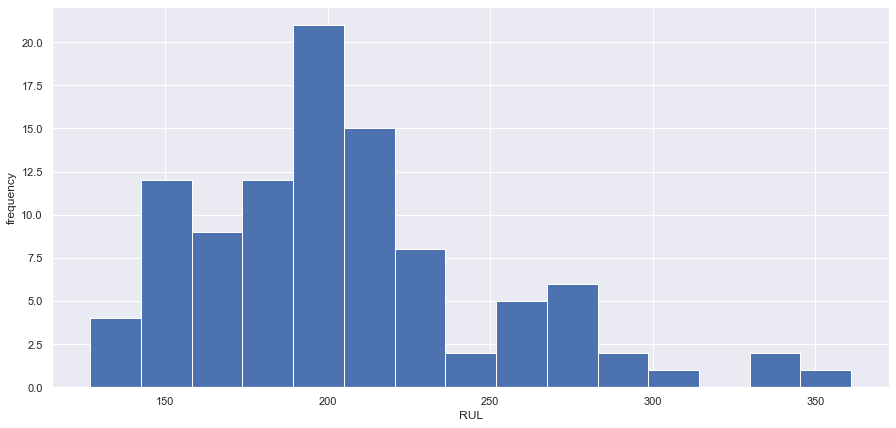

In [13]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [14]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as on 
# now we will keep it as it.


## Plotting of Sensor Values Vs RUL

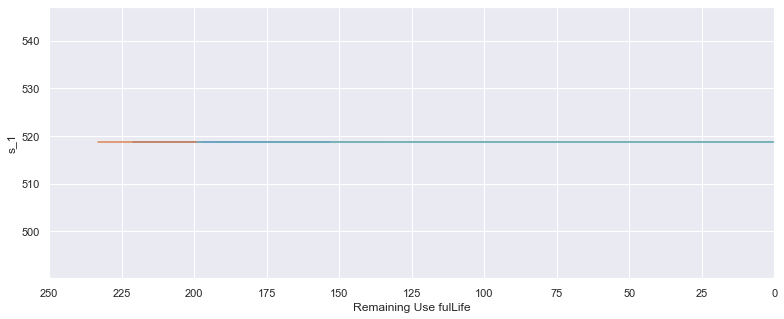

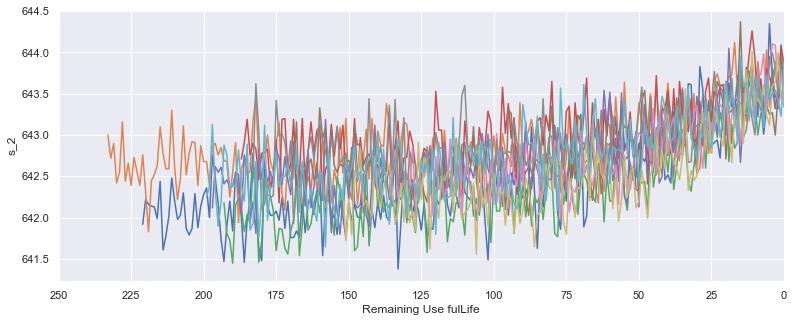

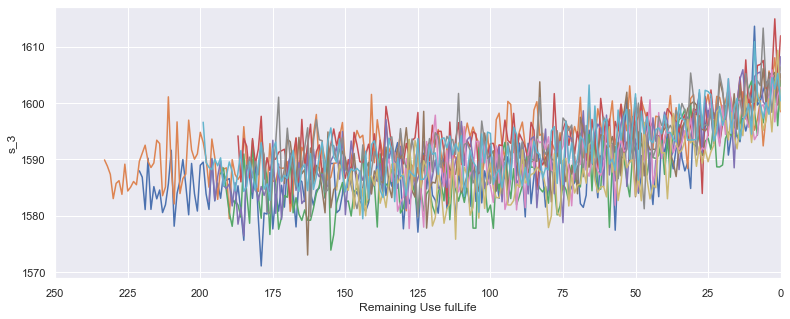

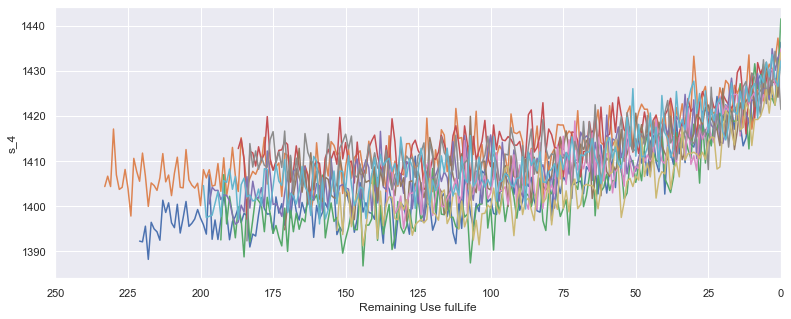

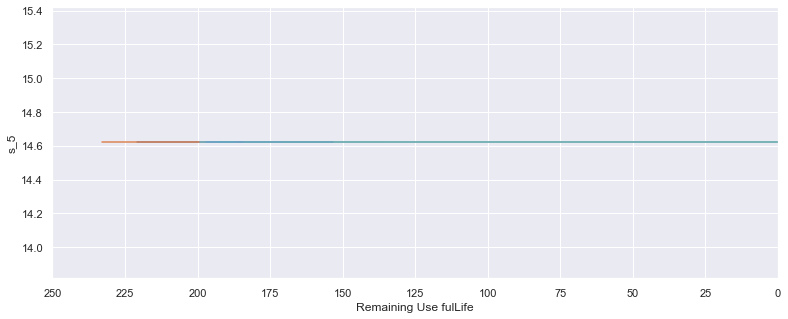

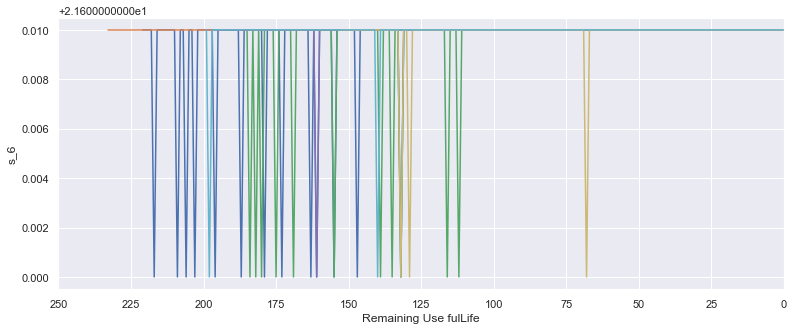

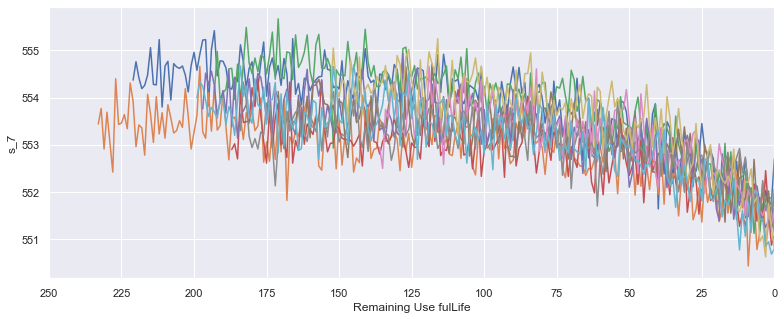

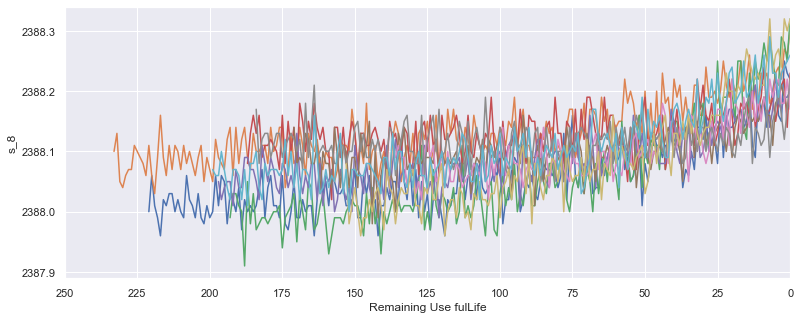

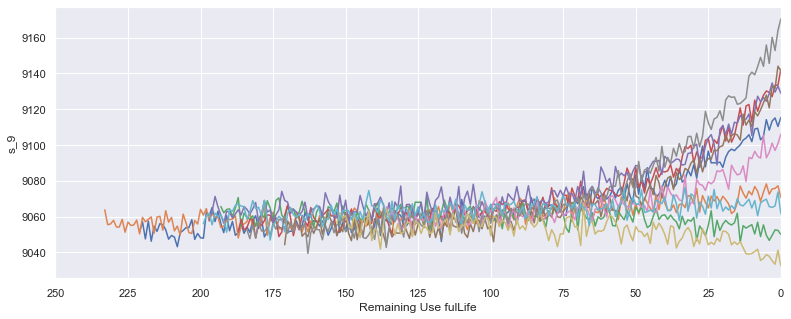

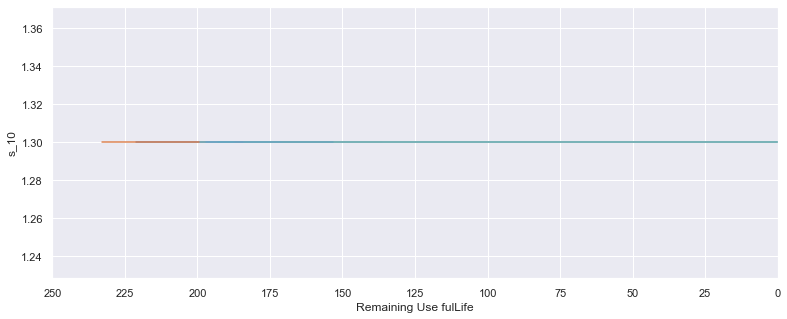

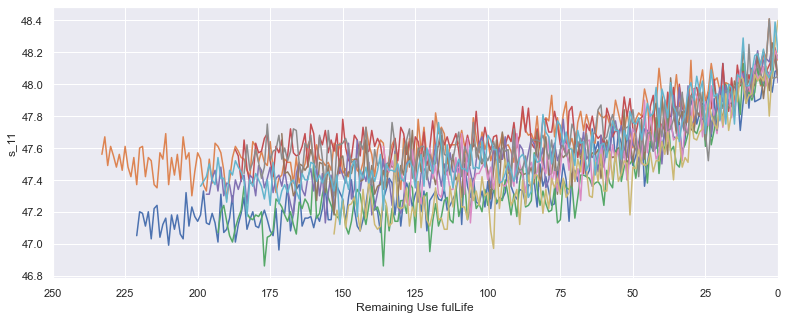

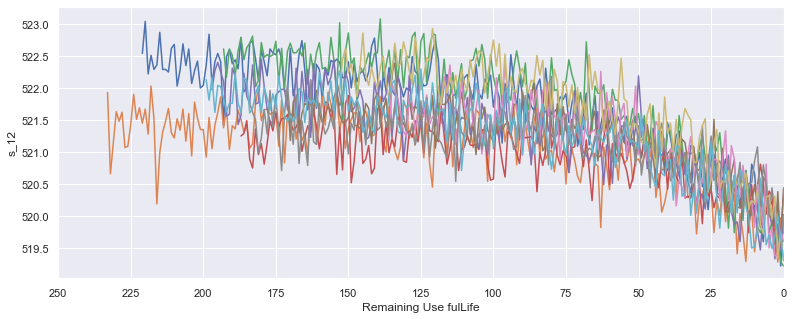

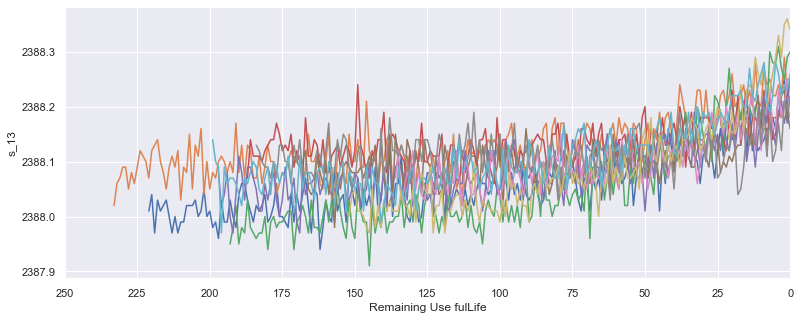

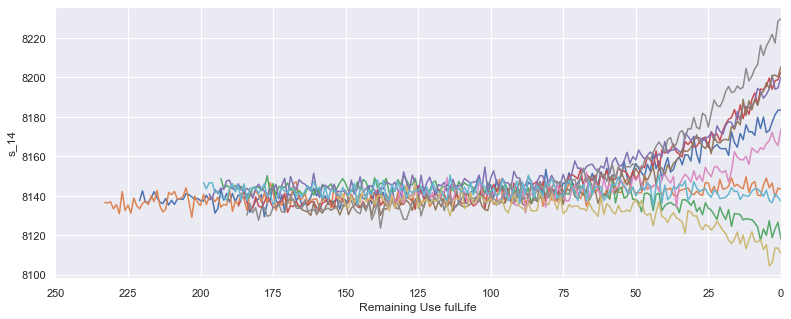

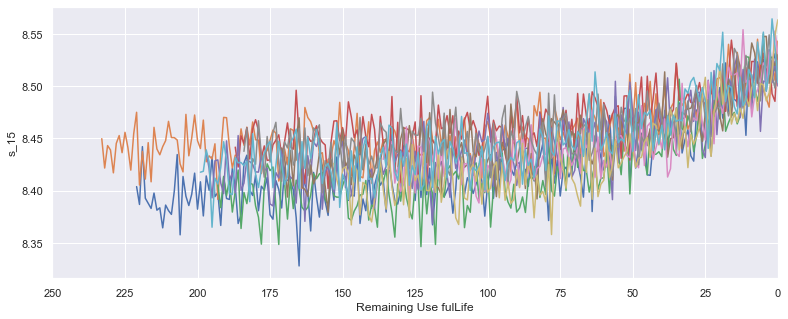

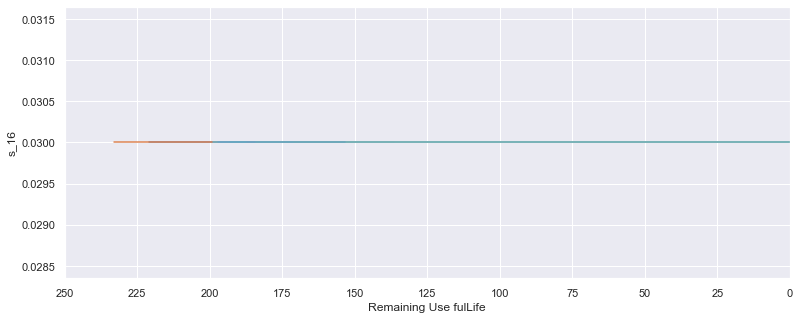

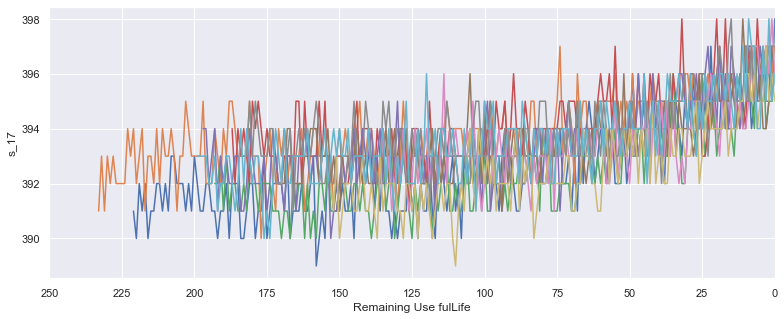

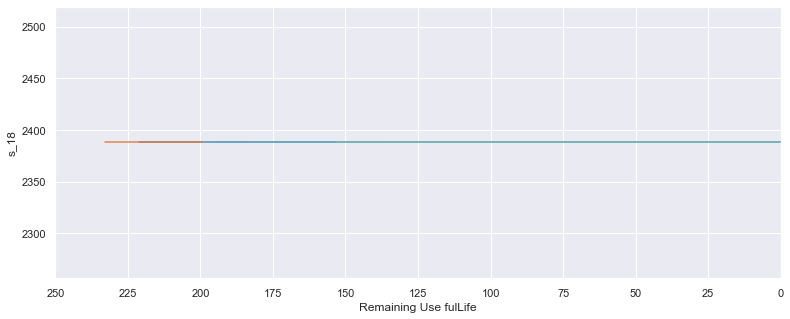

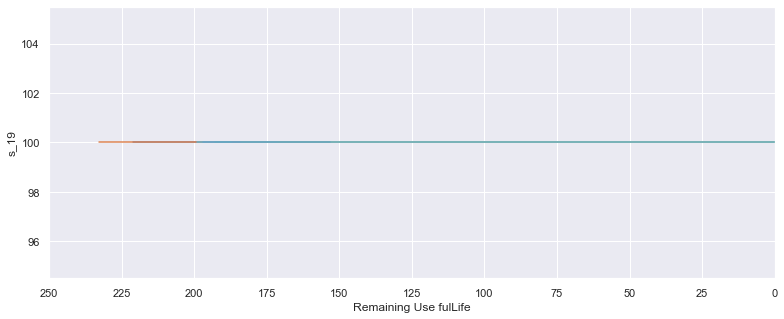

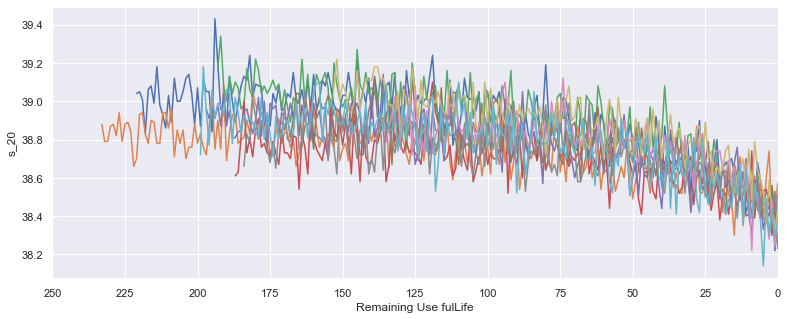

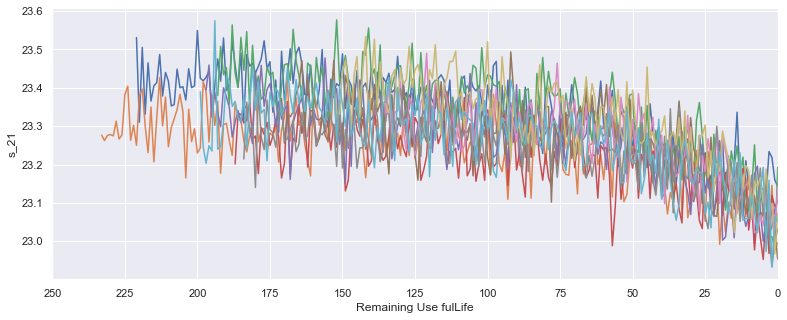

In [15]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [16]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

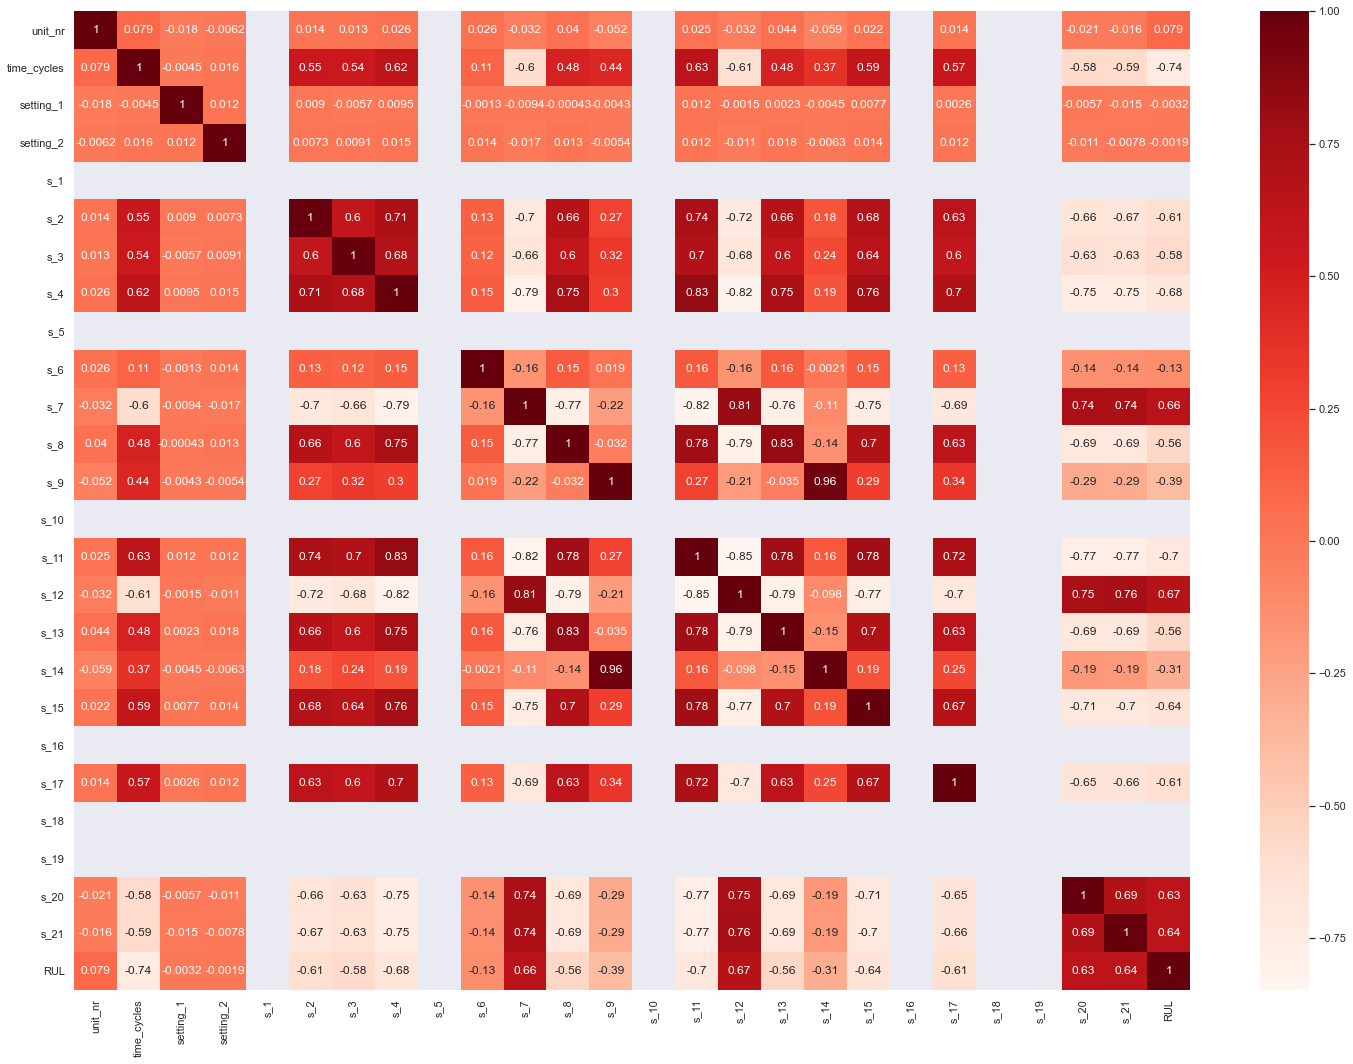

In [17]:
plt.figure(figsize=(25,18))
sns.heatmap(train.corr(),annot=True ,cmap='Reds')
plt.show()

In [18]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

time_cycles   -0.736241
s_2           -0.606484
s_3           -0.584520
s_4           -0.678948
s_7            0.657223
s_8           -0.563968
s_11          -0.696228
s_12           0.671983
s_13          -0.562569
s_15          -0.642667
s_17          -0.606154
s_20           0.629428
s_21           0.635662
RUL            1.000000
Name: RUL, dtype: float64

In [19]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

In [20]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [21]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [22]:
train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


## Seperating Train & Test Data

In [23]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044


In [24]:
test.head(5)

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,21.61,554.42,...,521.79,2388.06,8130.11,8.4024,0.03,393,2388,100.0,38.81,23.3552
1,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,21.61,553.52,...,521.74,2388.09,8126.90,8.4505,0.03,391,2388,100.0,38.81,23.2618
2,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,21.61,552.59,...,520.83,2388.14,8131.46,8.4119,0.03,395,2388,100.0,38.93,23.2740
3,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,21.61,552.64,...,521.88,2388.11,8133.64,8.4634,0.03,395,2388,100.0,38.58,23.2581
4,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,21.61,553.29,...,521.00,2388.15,8125.74,8.4362,0.03,394,2388,100.0,38.75,23.4117


In [25]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394,38.75,23.4117


In [26]:
y_test.head(5)

,RUL
0,112
1,98
2,69
3,82
4,91


In [27]:
# Clipping of RUL at 125 as after 125 , RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=125)

## Building Deep Learning ANN Model

### Simple ANN Model

In [28]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train)
X_test1 = sc.transform(X_test)

In [29]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop

In [30]:
X_train1.shape

(20631, 12)

In [31]:

# Initialising the ANN
regressor = Sequential()

# Adding the input layer and the first hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform',activation='relu',input_shape=(12,)))

# Adding the second hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform',activation='relu'))


# Adding the third hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform',activation='relu'))


# Adding the Fourth hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform',activation='relu'))

# Adding the Fifth hidden Layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform', activation = 'relu'))


# Adding the Sixth hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform', activation = 'relu'))


# Adding the Seventh hidden layer
regressor.add(Dense(20, kernel_initializer = 'he_uniform', activation = 'relu'))


# Adding the output layer
regressor.add(Dense( 1, kernel_initializer = 'glorot_uniform', activation = 'linear'))

# Compiling the ANN
#regressor.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])
regressor.compile(optimizer = RMSprop(0.001), loss = 'mean_absolute_error', metrics = ['mean_absolute_error'])

# RMSprop is optimizer like adam. 0.01 is learning 

In [32]:
# Other Optimizer are rmsprop , adam. Getting better accuracy woth rmsprop.

In [33]:
regressor.fit(X_train1,y_train,epochs=100)

Epoch 1/100
645/645 [==============================] - 0s 757us/step - loss: 26.1339 - mean_absolute_error: 26.1339
Epoch 2/100
645/645 [==============================] - 1s 1ms/step - loss: 17.0595 - mean_absolute_error: 17.0595
Epoch 3/100
645/645 [==============================] - 1s 2ms/step - loss: 16.0619 - mean_absolute_error: 16.0619
Epoch 4/100
645/645 [==============================] - 1s 2ms/step - loss: 15.5797 - mean_absolute_error: 15.5797
Epoch 5/100
645/645 [==============================] - 1s 2ms/step - loss: 15.3060 - mean_absolute_error: 15.3060
Epoch 6/100
645/645 [==============================] - 1s 2ms/step - loss: 15.0714 - mean_absolute_error: 15.0714
Epoch 7/100
645/645 [==============================] - 1s 2ms/step - loss: 14.8886 - mean_absolute_error: 14.8886
Epoch 8/100
645/645 [==============================] - 1s 2ms/step - loss: 14.7602 - mean_absolute_error: 14.7602
Epoch 9/100
645/645 [==============================] - 1s 2ms/step - loss: 14.6380 - m

645/645 [==============================] - 2s 3ms/step - loss: 13.5617 - mean_absolute_error: 13.5617
Epoch 72/100
645/645 [==============================] - 2s 3ms/step - loss: 13.5507 - mean_absolute_error: 13.5507
Epoch 73/100
645/645 [==============================] - 2s 2ms/step - loss: 13.5179 - mean_absolute_error: 13.5179
Epoch 74/100
645/645 [==============================] - 1s 2ms/step - loss: 13.5317 - mean_absolute_error: 13.5317
Epoch 75/100
645/645 [==============================] - 1s 2ms/step - loss: 13.5209 - mean_absolute_error: 13.5209
Epoch 76/100
645/645 [==============================] - 1s 2ms/step - loss: 13.5411 - mean_absolute_error: 13.5411
Epoch 77/100
645/645 [==============================] - 1s 2ms/step - loss: 13.4814 - mean_absolute_error: 13.4814
Epoch 78/100
645/645 [==============================] - 1s 2ms/step - loss: 13.4978 - mean_absolute_error: 13.4978
Epoch 79/100
645/645 [==============================] - 1s 2ms/step - loss: 13.4780 - mean_ab

In [34]:
y_hat=regressor.predict(X_train1)
r2_score(y_train,y_hat)

0.7281645793589278

In [35]:
y_hat_test=regressor.predict(X_test1)
r2_score(y_test,y_hat_test)

0.6591129381590728

### ANN Model with HyperParameter Tuning

HYPERPARAMETER TUNING

In [36]:
# Hyper parameter tuning is done using KERAS Regressor Class

In [37]:
# ----------------------------- Functional Tuning - Option 1: using Sklearn ------------------------------
# Goal: tune the batch size and epochs

# Import KerasRegressor class
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LeakyReLU

# Import the GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define the model trhough a user-defined function
def create_model(optimizer=RMSprop(0.01)):
    model = Sequential()
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1),kernel_initializer = 'he_uniform', input_shape=(12,)))
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1),kernel_initializer = 'he_uniform'))
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1),kernel_initializer = 'he_uniform'))
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1),kernel_initializer = 'he_uniform'))
    
    
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1) ,kernel_initializer = 'he_uniform'))
    
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1) ,kernel_initializer = 'he_uniform'))
    
    model.add(Dense(15, activation=LeakyReLU(alpha=0.1) ,kernel_initializer = 'he_uniform'))
    
    
    model.add(Dense(1,activation = 'linear',kernel_initializer = 'glorot_uniform'))
    model.compile(loss='mean_absolute_error', metrics=['mean_absolute_error'], optimizer='adam') # compile the model
    return model
model = KerasRegressor(build_fn=create_model, verbose=1)

# Define the hyperparameters grid to be validated
batch_size = [10, 20, 30, 40, 60, 80,100]
epochs = [10,50,75,100]
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
model = KerasRegressor(build_fn=create_model, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)

# Run the GridSearchCV process
grid_result = grid.fit(X_train1,y_train,verbose = 2)

# Print the results of the best model
print('Best params: ' + str(grid_result.best_params_))

2064/2064 - 3s - loss: 21.1891 - mean_absolute_error: 21.1891
Best params: {'batch_size': 10, 'nb_epoch': 100}


In [38]:
[grid_result.best_score_,grid_result.best_params_]

[-16.755358123779295, {'batch_size': 10, 'nb_epoch': 100}]

In [39]:
y_hat=grid.predict(X_train1)
r2_score(y_train,y_hat)

2064/2064 [==============================] - 2s 1ms/step


0.7248237518520075

In [40]:
y_hat_test=grid.predict(X_test1)
r2_score(y_test,y_hat_test)

10/10 [==============================] - 0s 2ms/step


0.7200568676485697